In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import pingouin as pg
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, chi2 
import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import pandahouse as ph


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# A/B Testing

## 1.1 Condition

One of the main tasks of an analyst in our team is to conduct experiments correctly. For this, we use the A/B testing method. During the testing of one hypothesis, the target group was offered a new payment mechanism on the website, while the control group retained the basic mechanism. My task is to analyze the results of the experiment and conclude whether it is worth launching the new payment mechanism for all users.

## 1.2 Input Data

The input data consists of 4 csv files:

- `groups.csv` – a file with information about the user's belonging to the control or experimental group (A – control, B – target group).
- `groups_add.csv` – an additional file with users, which was sent 2 days after the initial data transfer.
- `active_studs.csv` – a file with information about users who visited the platform during the experiment.
- `checks.csv` – a file with information about user payments during the experiment.

## 1.3 Questions

- What metrics should be considered during the analysis and why?
- Are there any differences in the indicators, and what could they be related to?
- Are these differences statistically significant?
- Should the new payment mechanism be launched for all users?

# EDA

In [2]:
def read_yd_csv(url_groups, separator):
    """
    Reads a CSV file from Yandex Disk using a public URL and the specified separator.
    
    Parameters:
    - url_groups (str): Public URL of the CSV file on Yandex Disk.
    - separator (str): Separator used in the CSV file.
    
    Returns:
    - df (DataFrame): DataFrame created from the downloaded CSV file.
    """
    
    # Base URL for accessing Yandex Disk
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Create the final URL for downloading the file,
    # combining the base URL and query parameters using urlencode() from the urllib.parse module
    final_url_groups = base_url + urlencode(dict(public_key=url_groups))  
    
    # Make a request to the Yandex Disk API to download the file using the final URL
    response_groups = requests.get(final_url_groups)  
    
    # The requests.get() function returns a response in JSON format, from which the download URL ('href') is extracted
    download_url_groups = response_groups.json()['href']
    
    # Read the CSV file using the obtained URL and specified separator
    df = pd.read_csv(download_url_groups, sep=separator)
    
    return df

In [3]:
df_groups = read_yd_csv('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';' )
df_groups_add = read_yd_csv('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',' )
df_active_studs = read_yd_csv('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ';' )
df_checks = read_yd_csv('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';' )

Check for duplicates in the data

In [4]:
groups = df_groups.id.duplicated().sum()
groups_add = df_groups_add.id.duplicated().sum()
active_studs = df_active_studs.student_id.duplicated().sum()
checks = df_checks.student_id.duplicated().sum()
print(f'''The number of duplicates in the data: 
groups - {groups};
groups_add - {groups_add};
active_studs - {active_studs};
checks - {checks}.''')

The number of duplicates in the data: 
groups - 0;
groups_add - 0;
active_studs - 0;
checks - 0.


Look at the size of the dataframes

In [5]:
groups = df_groups.shape[0]
groups_add = df_groups_add.shape[0]
active_studs = df_active_studs.shape[0]
checks = df_checks.shape[0]
print(f'''Dataframe sizes: 
groups - {groups};
groups_add - {groups_add};
active_studs - {active_studs};
checks - {checks}.''')

Dataframe sizes: 
groups - 74484;
groups_add - 92;
active_studs - 8341;
checks - 541.


Add an additional list with users to the main one

In [6]:
df_all_groups = df_groups.append(df_groups_add)

Are all active users on our list?

In [7]:
merged_df = df_all_groups.merge(df_active_studs, left_on='id', right_on='student_id', how='outer', indicator=True)
merged_df.head()

,id,grp,student_id,_merge
0,1489,B,NaN,left_only
1,1627,A,1627.0,both
2,1768,B,NaN,left_only
3,1783,B,NaN,left_only
4,1794,A,NaN,left_only


In [8]:
merged_df.groupby('_merge').size()

_merge
left_only     66235
right_only        0
both           8341
dtype: int64

I see that all active users are in the list (right_only =0)

I'll check if all the users who bought are active users?

In [9]:
merged_df = df_active_studs.merge(df_checks, on='student_id', how='outer', indicator=True)
merged_df.head()

,student_id,rev,_merge
0,581585,NaN,left_only
1,5723133,NaN,left_only
2,3276743,NaN,left_only
3,4238589,NaN,left_only
4,4475369,NaN,left_only


In [10]:
merged_df.groupby('_merge').size()

_merge
left_only     7949
right_only     149
both           392
dtype: int64

I see that there are 149 users who bought something, but not on the days of the experiment, so they should not be taken into account. 

I'll save the IDs of these users to further clarify the reason for the user data entering our data.

In [11]:
id_wrong = merged_df.query('_merge == "right_only"').student_id

In [12]:
# Check if there is an intersection between user groups (Using sets)
gr_a = set(df_all_groups.query("grp=='A'").id)
gr_b = set(df_all_groups.query("grp=='B'").id)

gr_a.intersection(gr_b)

set()

There is an empty set, i.e. these two sets do not intersect and we can conduct AB testing

# Data preprocessing

In [13]:
# Сonnect information about the group to active users 
df_active_groups = df_active_studs.merge(df_all_groups, left_on="student_id", right_on = "id")


In [14]:
# Add the payment attribute to the dataframe and the payment itself
df = df_active_groups.merge(df_checks, how ='left', on = 'student_id')
df['paid'] = np.where(df['rev'].isnull(), 0,1)

In [15]:
# Fill in the missing values in the rev column with zeros for users who have not made purchases
df['rev'].fillna(0, inplace=True)
df.head()

,student_id,id,grp,rev,paid
0,581585,581585,A,0.0,0
1,5723133,5723133,A,0.0,0
2,3276743,3276743,B,0.0,0
3,4238589,4238589,A,0.0,0
4,4475369,4475369,B,0.0,0


In [16]:
# The sizes of groups A and B
df.groupby('grp').size()

grp
A    1538
B    6803
dtype: int64

Are services being re-purchased?

In [17]:
# Only purchases 
df_paid = df.query('paid == 1')

In [18]:
# Counting the number of orders per user:
ord_per_user = df_paid.groupby(["grp", "id"], as_index=False).size()
ord_per_user.head()

,grp,id,size
0,A,1627,1
1,A,287008,1
2,A,332387,1
3,A,347455,1
4,A,445767,1


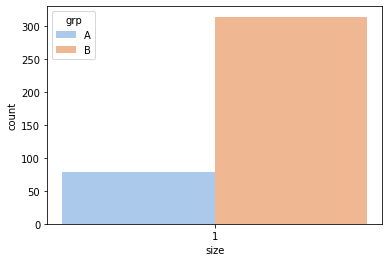

In [19]:
# Schedule
sns.countplot(data=ord_per_user, x="size", hue="grp" , palette="pastel")

I see that the user bought only once in both the test and control group, but the number of purchases increased in the test group

# Metrics

### 1. Conversion Rate

The percentage of users who made a purchase out of the total number of active users.

**Formula:**

> Conversion Rate = (Number of users who made a purchase / Total number of active users) × 100

### 2. Average Revenue Per User (ARPU)

The average revenue generated from each active user.

**Formula:**

> ARPU = Total Revenue / Total number of active users

### 3. Average Revenue Per Paying User (ARPPU)

The average revenue from users who made a purchase.

**Formula:**

> ARPPU = Total revenue from paying users / Number of paying users

# Hypothesis testing

## Hypothesis 1:

The conversion rate has changed.

> Conversion Rate = (Number of users who made a purchase / Total number of active users) × 100

> 𝐻0: The conversion rate is the same in the control and test groups.

> 𝐻1: The conversion rate differs between the control and test groups.


In [20]:
# Common CR for the control and test group
CR = (df.query('paid == 1')\
      .groupby('grp')\
      .agg({'student_id': 'count'}) / df.groupby('grp')\
                                        .agg({'student_id': 'count'})).mul(100).round(2)

CR

,student_id
grp,
A,5.07
B,4.62


In [21]:
df_CR = df.groupby(['grp', 'paid'], as_index = False)\
    .agg({'student_id': 'count'})\
    .rename(columns ={'student_id':'count'})

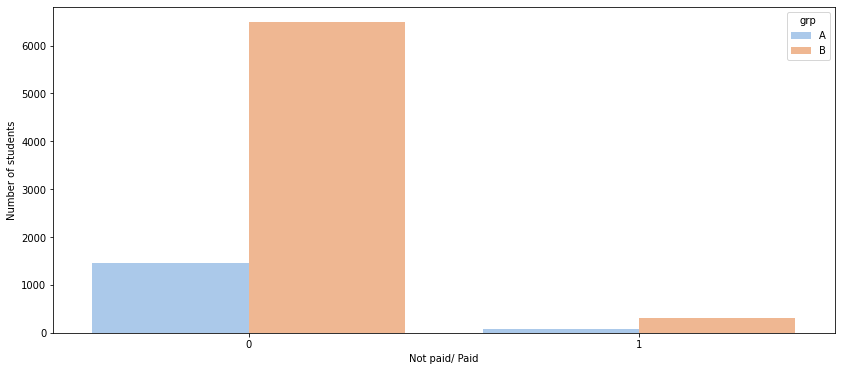

In [22]:
# Schedule
plt.figure(figsize=(14, 6))
sns.barplot(x='paid', y='count', hue='grp', data=df_CR, palette="pastel")
plt.xlabel('Not paid/ Paid')
plt.ylabel('Number of students')
plt.show()


### Visual Inspection

A visual inspection shows that in the test group, user activity and the number of paid orders have increased compared to the control group. However, the conversion rate from activity to purchase has decreased:
- In group A, CR = 5.07%
- In group B, CR = 4.62%

It is necessary to check whether the new payment mechanism actually decreased the purchase conversion rate.

For this, I will use the chi-square test, as it involves categorical variables and we need to compare proportions between the groups.



In [23]:
pd.crosstab(df.grp, df.paid)

paid,0,1
grp,,
A,1460,78
B,6489,314


## Testing

In [24]:
exp, obs, stats = pg.chi2_independence(data=df, 
                                       x="grp", 
                                       y="paid")

In [25]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


### p-value greater than 0.05 means the result is NOT statistically significant

Therefore, we cannot reject the null hypothesis.

> The null hypothesis is NOT rejected --> we could not prove that the new payment mechanism decreased the purchase conversion rate.

## Hypothesis 2:

The average revenue per active user has changed.

> ARPU = Total Revenue / Total number of active users

> 𝐻0: The average revenue per active user is the same in groups A and B.

> 𝐻1: The average revenue per active user differs between groups A and B.

In [26]:
# ARPU:
arpu = df.groupby('grp')['rev'].mean().reset_index().round(2)
arpu

,grp,rev
0,A,47.35
1,B,58.06


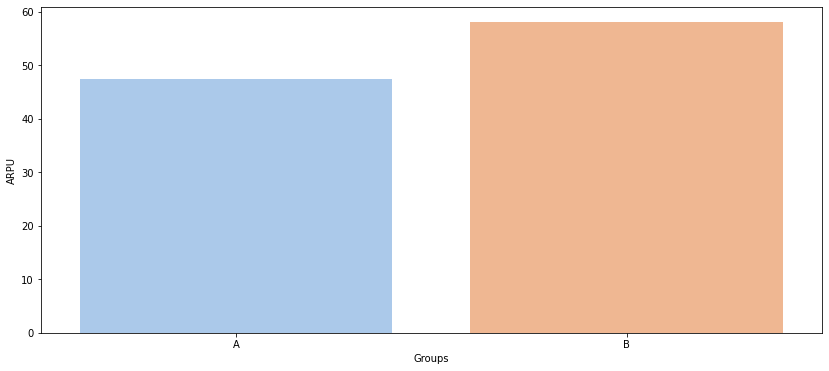

In [27]:
# Schedule
plt.figure(figsize=(14, 6))
sns.barplot(data=arpu, x='grp', y='rev', palette="pastel")
plt.ylabel('ARPU')
plt.xlabel('Groups')
plt.show()




# Checking for the normality of the distribution

In [28]:
group_a = df[df['grp'] == 'A']['rev']
group_b = df[df['grp'] == 'B']['rev']

<Figure size 432x288 with 0 Axes>

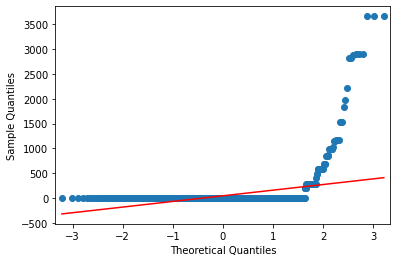

In [29]:
plt.figure()
sm.qqplot( group_a, line="r")
plt.show()


<Figure size 432x288 with 0 Axes>

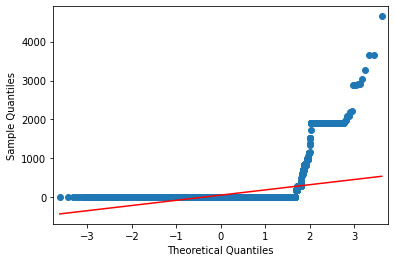

In [30]:
plt.figure()
sm.qqplot( group_b, line="r")
plt.show()

In [31]:
pg.normality(data=df, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


The data is not normally distributed.

Let's examine the distribution of order amounts for the test and control groups.

Text(0, 0.5, 'Frequency')

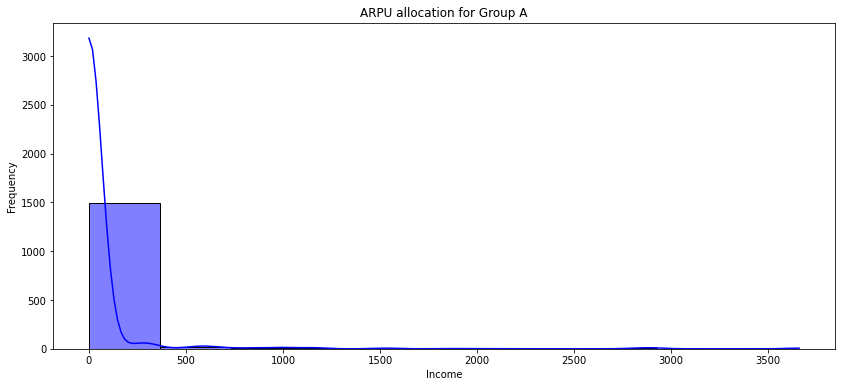

In [32]:
plt.figure(figsize=(14, 6))
sns.histplot(group_a, kde=True, color='blue', bins=10)
plt.title('ARPU allocation for Group A')
plt.xlabel('Income')
plt.ylabel('Frequency')


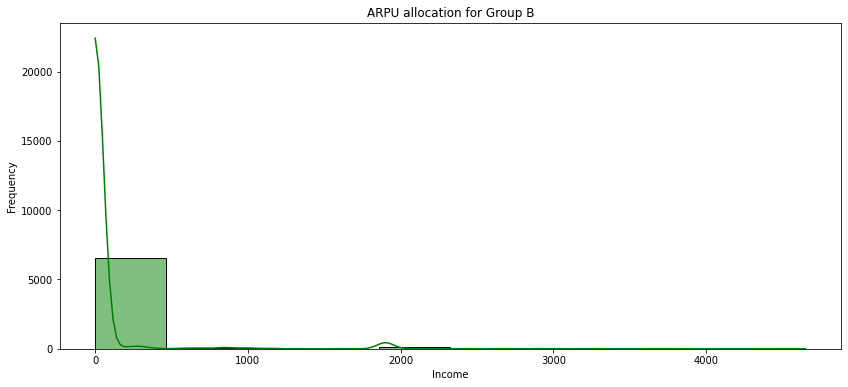

In [33]:
plt.figure(figsize=(14, 6))
sns.histplot(group_b, kde=True, color='green', bins=10)
plt.title('ARPU allocation for Group B')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

### Visual Inspection

A visual inspection shows that the average revenue per user has increased in the test group compared to the control group:

- In group A, ARPU = 47.35
- In group B, ARPU = 58.06

It is necessary to check whether the new payment mechanism actually increased the average revenue per active user.

The data is not normally distributed, but the sample size is sufficiently large (>30).

For this, I will use a t-test, but I will first test for the equality of variances between the two distributions.


## Testing

> 𝐻0: The variances are equal.

> 𝐻1: The variances are different.

In [34]:
# Checking the equality of variances using the Levene criterion
ss.levene(group_a, group_b)

LeveneResult(statistic=1.5014608294336371, pvalue=0.22048133327049665)

### pvalue= 0.22048133327049665 

The variances are equal in the two groups.

In [35]:
pg.ttest(x=df.query('grp == "A"')['rev'], 
         y=df.query('grp == "B"')['rev'], correction=False )

# correction=False because the variances are not different

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.225341,8339,two-sided,0.220481,"[-27.85, 6.42]",0.034597,0.067,0.231965


### p-value = 0.220481 means the result is NOT statistically significant

Therefore, we cannot reject the null hypothesis.

> The null hypothesis is NOT rejected --> we could not prove that the new payment mechanism increased the average revenue per active user.

## Hypothesis 3:

The average revenue per paying user has increased.

> ARPPU = Total revenue from paying users / Number of paying users

> 𝐻0: The average revenue per paying user is the same in groups A and B.

> 𝐻1: The average revenue per paying user differs between groups A and B.

In [36]:
df_paid.head()

,student_id,id,grp,rev,paid
62,1184303,1184303,A,1530.0000,1
67,3354191,3354191,B,1900.0001,1
77,3278734,3278734,B,1900.0000,1
99,720651,720651,A,1980.0000,1
193,1232221,1232221,B,1900.0000,1


In [37]:
# ARPPU:
arppu = df_paid.groupby('grp')['rev'].mean().reset_index().round(2)
arppu

,grp,rev
0,A,933.59
1,B,1257.88


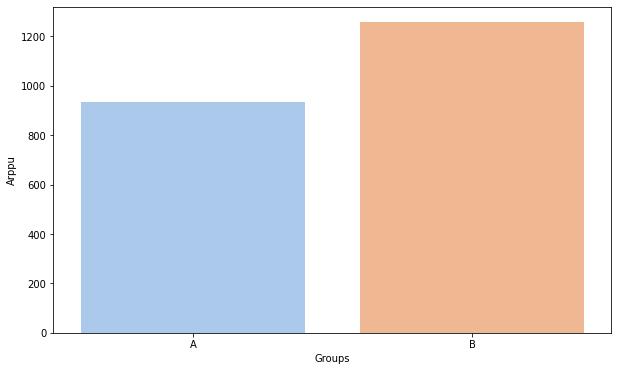

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(data=arppu, x='grp', y='rev', palette='pastel')
plt.ylabel('Arppu')
plt.xlabel('Groups')

plt.show()


# Checking for the normality of the distribution

In [39]:
group_arppu_a = df_paid[df_paid['grp'] == 'A']['rev']
group_arppu_b = df_paid[df_paid['grp'] == 'B']['rev']

<Figure size 432x288 with 0 Axes>

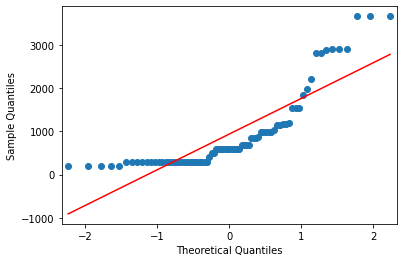

In [40]:
plt.figure()
sm.qqplot( group_arppu_a, line="r")
plt.show()


<Figure size 432x288 with 0 Axes>

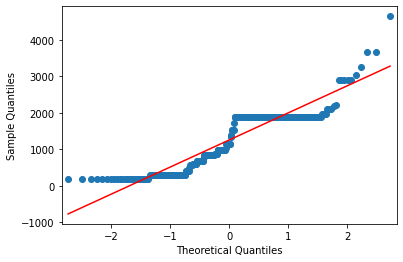

In [41]:
plt.figure()
sm.qqplot( group_arppu_b, line="r")
plt.show()

In [42]:
pg.normality(data=df_paid, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


The data is not normally distributed.

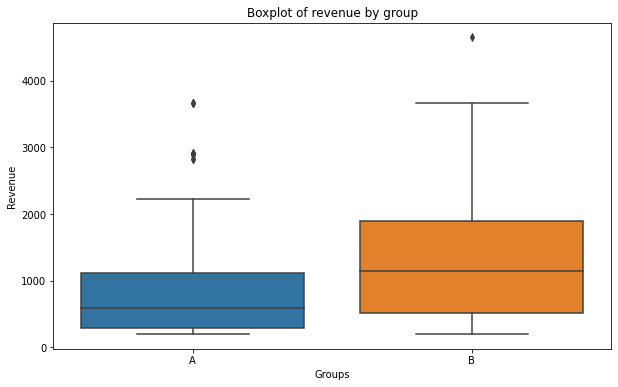

In [43]:
# Build a boxplot schedule by groups for paid orders
plt.figure(figsize=(10, 6))
sns.boxplot(x='grp', y='rev', data=df_paid)
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.title('Boxplot of revenue by group')
plt.show()

Let's look at the distribution of the amount of orders for the test and control groups. 

Text(0, 0.5, 'Frequency')

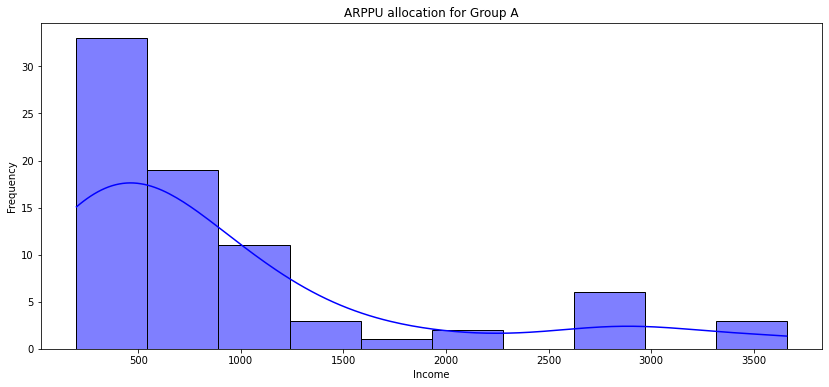

In [44]:
plt.figure(figsize=(14, 6))
sns.histplot(group_arppu_a, kde=True, color='blue', bins=10)
plt.title('ARPPU allocation for Group A')
plt.xlabel('Income')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

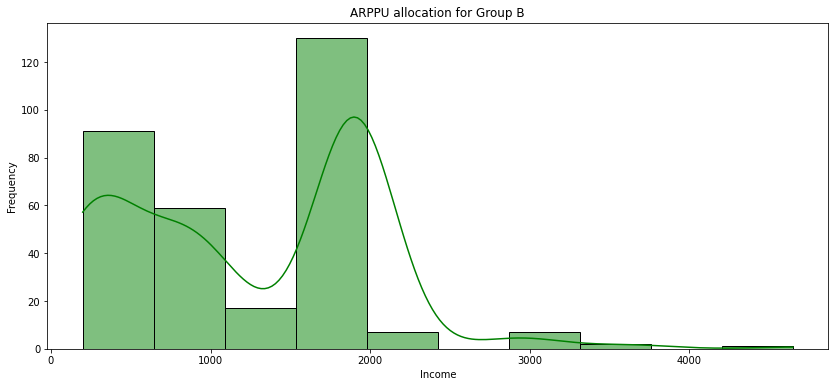

In [45]:
plt.figure(figsize=(14, 6))
sns.histplot(group_arppu_b, kde=True, color='green', bins=10)
plt.title('ARPPU allocation for Group B')
plt.xlabel('Income')
plt.ylabel('Frequency')

### Visual Inspection

A visual inspection shows that the average transaction amount has increased in the test group compared to the control group:

- In group A = 933.59
- In group B = 1257.88

It is necessary to check whether the new payment mechanism actually increased the average revenue per paying user.

The data is not normally distributed, but the sample size is sufficiently large (>30).

For this, I will use a t-test, but I will first test for the equality of variances between the two distributions.

## Testing

> 𝐻0: The variances are equal.

> 𝐻1: The variances are different.

In [46]:
# Проверка равенства дисперсий с помощью критерия Левена
ss.levene(group_arppu_a, group_arppu_b)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

### pvalue= 0.08025675761347022

The variances are equal in the two groups.

In [47]:
pg.ttest(group_arppu_a, group_arppu_b, correction=False)
# correction=False because the variances are not different

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.13378,390,two-sided,0.001856,"[-527.74, -120.84]",0.39646,14.001,0.878211


### p-value = 0.001856 means the result is statistically significant

Therefore, we can reject the null hypothesis.

> The null hypothesis is rejected

- The average revenue per paying user in groups A and B differs in favor of the test group B.

- According to the 95% confidence interval, the revenue in the control group (group A) was on average 120 to 527 units less than in the test group (group B).

Thus, the results of the t-test show significant differences in the average revenue per paying user between the control and test groups.

The test group demonstrates higher revenue, which is confirmed by statistically significant results and corresponding metrics.

# Conclusion

Based on the conducted tests and data analysis, the following conclusions can be made:

- User Conversion (Hypothesis 1): The change in the payment mechanism did not have a significant impact on the percentage of active users who made a purchase. The conversion rate in the control and test groups remained virtually unchanged, as confirmed by statistical tests.

- Average Revenue Per User (ARPU, Hypothesis 2): The new payment mechanism did not lead to a significant increase in average revenue per active user. The difference in ARPU between the control and test groups is not statistically significant.

- Average Revenue Per Paying User (ARPPU, Hypothesis 3): The new payment mechanism led to a significant increase in average revenue per paying user. The test results showed that the average revenue per paying user in the test group is substantially higher than in the control group.

## Recommendations

Continuation of the new payment mechanism:
Despite the lack of significant changes in conversion and average revenue per active user, the substantial increase in average revenue per paying user indicates a positive impact of the new payment mechanism.

It is recommended to continue using the new mechanism with possible optimization to increase conversion.

# SQL

### The goal is to write an optimal query that identifies the number of very diligent students.

### Condition:
Educational courses consist of various lessons, each of which is made up of several small tasks. Each such small task is called a "pea."

A student is considered "very diligent" if they have correctly solved at least 20 peas at least once in the current month.

### Table
**default.peas**

| Attribute Name | Attribute Type | Description                                    |
|----------------|----------------|------------------------------------------------|
| st_id          | int            | Student ID                                     |
| timest         | timestamp      | Time of solving the pea                        |
| correct        | bool           | Whether the pea was solved correctly           |
| subject        | text           | Discipline in which the pea is located         |

### Steps to Perform the Task

1. **Load Data**: Connect to your SQL database and load the necessary table.
2. **Write SQL Query**: Write the SQL query to find students who have correctly solved at least 20 peas in the current month.
3. **Execute and Analyze**: Execute the query and analyze the results.


In [48]:
# connection parameters
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [49]:
# Request and get data from clickhouse to pandas dataframe
query = """
SELECT 
    COUNT(*)
FROM (
    WITH (
        SELECT MAX(toStartOfMonth(timest))
        FROM peas
        ) As last_date
        
    SELECT 
        st_id,
        COUNT(correct) as count_corrct
    FROM 
        peas
    WHERE 
         correct = 1 AND toStartOfMonth(timest) = last_date
    GROUP BY 
        st_id
    )
WHERE
count_corrct > 19 
"""
df = ph.read_clickhouse(query, connection=connection_default)
print(f'Total number of diligent students: {df.iloc[0,0]}')

Total number of diligent students: 136


# SQL
### Objective: Need to extract the following information about user groups in a single query:

- **ARPU (Average Revenue Per User)**
- **ARPAU (Average Revenue Per Active User)**
- **CR (Conversion Rate) to purchase**
- **CR of active users to purchase**
- **CR of users from activity in math (subject = 'math') to purchasing the math course**

#### Definitions:

- **ARPU** is calculated relative to all users in the groups.
- **Active user** is defined as a user who has correctly solved more than 10 tasks in any discipline.
- **Active in math** is defined as a user who has correctly solved 2 or more tasks in math.

### Condition

The educational platform offers students a trial model where they can solve up to 30 peas for free each day. To access an unlimited number of tasks in a specific discipline, students need to purchase full access.

The team conducted an experiment testing a new payment screen.

### Tables

**default.peas**

| Attribute Name | Attribute Type | Description                                    |
|----------------|----------------|------------------------------------------------|
| st_id          | int            | Student ID                                     |
| timest         | timestamp      | Time of solving the pea                        |
| correct        | bool           | Whether the pea was solved correctly           |
| subject        | text           | Discipline in which the pea is located         |

**default.studs**

| Attribute Name | Attribute Type | Description                                    |
|----------------|----------------|------------------------------------------------|
| st_id          | int            | Student ID                                     |
| test_grp       | text           | Label of the student in this experiment        |

**default.final_project_check**

| Attribute Name | Attribute Type | Description                                    |
|----------------|----------------|------------------------------------------------|
| st_id          | int            | Student ID                                     |
| sale_time      | timestamp      | Time of purchase                              |
| money          | int            | Price at which the course was purchased       |
| subject        | text           | Discipline in which the course was purchased  |




In [50]:
# Request and get data from clickhouse to pandas dataframe
query = """
SELECT
  all_studs.test_grp AS grp,
  SUM(paid.money) / COUNT(DISTINCT all_studs.st_id) AS ARPU,
  SUM(paid.money) / COUNT(DISTINCT activ.st_id) as ARPAU,
  COUNT(DISTINCT paid.st_id) / COUNT(DISTINCT all_studs.st_id) as CR,
  COUNT(DISTINCT paid.st_id) / COUNT(DISTINCT activ.st_id) as CR_activ,
  COUNT(DISTINCT paid_math.st_id) / COUNT(DISTINCT activ_math.st_id) as CR_math
FROM
  studs AS all_studs --- все студенты
  LEFT JOIN (
    SELECT
      a.st_id,
      COUNT(a.st_id) AS count_correct,
      b.test_grp AS test_grp
    FROM
      peas AS a
      LEFT JOIN studs AS b ON a.st_id = b.st_id
    WHERE
      a.correct == 1
    GROUP BY
      b.test_grp,
      a.st_id
    HAVING
      count_correct > 10
  ) AS activ --- активные студенты
  ON all_studs.st_id = activ.st_id
  LEFT JOIN final_project_check AS paid --- все кто оплатил
  ON all_studs.st_id = paid.st_id
  LEFT JOIN (
    SELECT
      a.st_id,
      COUNT(*) as count_correct,
      b.test_grp as test_grp
    FROM
      peas as a
      LEFT JOIN studs as b ON a.st_id = b.st_id
    WHERE
      correct == 1
      and subject == 'Math'
    GROUP BY
      b.test_grp,
      a.st_id
    HAVING
      count_correct >= 2
  ) as activ_math --- активные по математике
  ON all_studs.st_id = activ_math.st_id
  LEFT JOIN (
    SELECT
      b.test_grp,
      a.st_id
    FROM
      final_project_check as a
      LEFT JOIN studs as b ON a.st_id = b.st_id
    WHERE
      subject = 'Math'
    GROUP BY
      b.test_grp,
      a.st_id
  ) as paid_math -- все кто оплатил математику
  ON all_studs.st_id = paid_math.st_id
GROUP BY
  all_studs.test_grp
 
"""
answer = ph.read_clickhouse(query=query, connection=connection_default)
answer.round(2)

,grp,ARPU,ARPAU,CR,CR_activ,CR_math
0,control,4540.98,10820.31,0.05,0.12,0.18
1,pilot,11508.47,35000.00,0.11,0.34,0.40


# Python

## Objective

1. **Implement a function** that automatically loads information from the additional file `groups_add.csv` (headers might differ) and recalculates metrics based on additional parameters.

2. **Implement a function** that generates plots for the obtained metrics.

To achieve this, the following functions will be implemented:

1. **Preprocessing Function**: Preprocesses the data similarly to how it was done in the first task.
2. **Metrics Calculation Function**: Calculates the metrics chosen in the first task.
3. **Data Loading Function**: Opens and loads data from the additional file.
4. **Plotting Function**: Generates plots based on the metrics.

In [51]:
def read_yd_csv(url_groups, separator):
    """
    Reads a CSV file from Yandex Disk using a public URL and the specified separator.
    
    Parameters:
    - url_groups (str): Public URL of the CSV file on Yandex Disk.
    - separator (str): Separator used in the CSV file.
    
    Returns:
    - df (DataFrame): DataFrame created from the downloaded CSV file.
    """
    
    # Base URL for accessing Yandex Disk
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Create the final URL for downloading the file,
    # combining the base URL and query parameters using urlencode() from the urllib.parse module
    final_url_groups = base_url + urlencode(dict(public_key=url_groups))  
    
    # Make a request to the Yandex Disk API to download the file using the final URL
    response_groups = requests.get(final_url_groups)  
    
    # The requests.get() function returns a response in JSON format, from which the download URL ('href') is extracted
    download_url_groups = response_groups.json()['href']
    
    # Read the CSV file using the obtained URL and specified separator
    df = pd.read_csv(download_url_groups, sep=separator)
    
    return df

In [52]:
df_groups = read_yd_csv('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';')
df_active_studs = read_yd_csv('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ';' )
df_checks = read_yd_csv('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')

### 1. Conversion Rate

The percentage of users who made a purchase out of the total number of active users.

**Formula:**

> Conversion Rate = (Number of users who made a purchase / Total number of active users) × 100

### 2. Average Revenue Per User (ARPU)

The average revenue generated from each active user.

**Formula:**

> ARPU = Total Revenue / Total number of active users

### 3. Average Revenue Per Paying User (ARPPU)

The average revenue from users who made a purchase.

**Formula:**

> ARPPU = Total revenue from paying users / Number of paying users


In [53]:
def preparation(df):
    """
    Preprocesses data for further analysis.

    The function performs the following steps:
    1. Merges active student data with the input DataFrame based on student_id.
    2. Merges the resulting data with payment data based on student_id.
    3. Adds a new column 'paid' which takes the value 1 if there is a payment record, and 0 if there is no record.
    4. Fills missing values in the 'rev' column with zeros.

    Parameters:
    df (DataFrame): Input DataFrame containing student data.

    Returns:
    DataFrame: Preprocessed DataFrame.
    """
    # Merge active student data with the input DataFrame
    df = df_active_studs.merge(df, left_on="student_id", right_on="id")
    
    # Merge the resulting data with payment data
    df = df.merge(df_checks, how='left', on='student_id')
    
    # Add 'paid' column
    df['paid'] = np.where(df['rev'].isnull(), 0, 1)
    
    # Fill missing values in the 'rev' column with zeros
    df['rev'].fillna(0, inplace=True)
    
    return df


In [54]:
df = preparation(df_groups)
df.head()

,student_id,id,grp,rev,paid
0,581585,581585,A,0.0,0
1,3276743,3276743,B,0.0,0
2,4238589,4238589,A,0.0,0
3,4475369,4475369,B,0.0,0
4,5481015,5481015,B,0.0,0


In [55]:
def metrics(df):
    """
    Calculates and returns selected metrics for analysis.

    The function performs the following steps:
    1. Calculates Conversion Rate (CR) - the percentage of users who made a purchase out of the active users.
    2. Calculates Average Revenue Per User (ARPU).
    3. Calculates Average Revenue Per Paying User (ARPPU).

    Parameters:
    df (DataFrame): Input DataFrame containing student data, their activity, and payment information.

    Returns:
    DataFrame: DataFrame with calculated metrics (CR, ARPU, ARPPU) for each group.
    """
    # Calculate Conversion Rate (CR)
    CR = (
        df.query('paid == 1')
        .groupby('grp')
        .agg({'student_id': 'count'}) / 
        df.groupby('grp')
        .agg({'student_id': 'count'})
    ).mul(100).reset_index().rename(columns={'student_id': 'CR'}).round(2)
    
    # Calculate Average Revenue Per User (ARPU)
    ARPU = df.groupby('grp')['rev'].mean().reset_index().rename(columns={'rev': 'ARPU'}).round(2)
    
    # Calculate Average Revenue Per Paying User (ARPPU)
    ARPPU = df.query('paid == 1').groupby('grp')['rev'].mean().reset_index().rename(columns={'rev': 'ARPPU'}).round(2)
    
    # Combine all metrics into one DataFrame
    result = pd.concat([CR.set_index('grp'), ARPU.set_index('grp'), ARPPU.set_index('grp')], axis=1).reset_index()
    
    return result



In [56]:
# Displaying metrics before adding additional information
first_metriks = metrics(df)
first_metriks 

,grp,CR,ARPU,ARPPU
0,A,5.08,47.44,933.59
1,B,4.61,57.86,1255.83


In [57]:
def add_data(url_groups, separator, df_groups):
    """
    Adds an additional list of user IDs to the main DataFrame and calculates metrics.

    The function performs the following steps:
    1. Downloads new user data from Yandex Disk.
    2. Renames columns for compatibility.
    3. Merges the main user list with the additional one.
    4. Preprocesses the merged data.
    5. Calculates metrics for the merged DataFrame.

    Parameters:
    url_groups (str): Public URL on Yandex Disk for downloading the data.
    separator (str): Separator used in the CSV file.
    df_groups (DataFrame): Main DataFrame with user data.

    Returns:
    DataFrame: DataFrame with calculated metrics (CR, ARPU, ARPPU) for each group.
    """
    # Read the new data
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url_groups = base_url + urlencode(dict(public_key=url_groups))
    response_groups = requests.get(final_url_groups)
    download_url_groups = response_groups.json()['href']
    df_add = pd.read_csv(download_url_groups, sep=separator)
    
    # Rename columns
    df_add.columns = ['id', 'grp']
    
    # Add the additional list of users to the main one
    df_groups_2 = pd.concat([df_groups, df_add], ignore_index=True)
    
    # Preprocess the merged data
    df_new = preparation(df_groups_2)
    
    # Calculate metrics for the merged DataFrame
    new_result = metrics(df_new)
    
    return new_result


In [58]:
# Displaying metrics with additional user IDs
new_metric = add_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',', df_groups)
new_metric

,grp,CR,ARPU,ARPPU
0,A,5.07,47.35,933.59
1,B,4.62,58.06,1257.88


In [59]:
def graphics(metrics):
    """
    Creates plots for the obtained metrics.

    The function generates 3 plots in the form of subplots:
    1. Conversion Rate (CR)
    2. Average Revenue Per User (ARPU)
    3. Average Revenue Per Paying User (ARPPU)

    Parameters:
    metrics (DataFrame): DataFrame with calculated metrics (CR, ARPU, ARPPU) for each group.

    Returns:
    None
    """
    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    sns.set_palette("pastel")
    
    # Conversion Rate (CR)
    sns.barplot(ax=axes[0, 0], data=metrics, x='grp', y='CR')
    axes[0, 0].set_ylabel('CR, %')
    axes[0, 0].set_xlabel('Groups')
    axes[0, 0].set_title('Conversion Rate')
    
    # Average Revenue Per User (ARPU)
    sns.barplot(ax=axes[0, 1], data=metrics, x='grp', y='ARPU')
    axes[0, 1].set_ylabel('ARPU')
    axes[0, 1].set_xlabel('Groups')
    axes[0, 1].set_title('Average Revenue Per User (ARPU)')
    
    # Remove unused subplot (leave it empty)
    fig.delaxes(axes[1, 0])
    
    # Average Revenue Per Paying User (ARPPU)
    sns.barplot(ax=axes[1, 1], data=metrics, x='grp', y='ARPPU')
    axes[1, 1].set_ylabel('ARPPU')
    axes[1, 1].set_xlabel('Groups')
    axes[1, 1].set_title('Average Revenue Per Paying User (ARPPU)')

    # Automatically adjust the figure layout
    plt.tight_layout()
    plt.show()


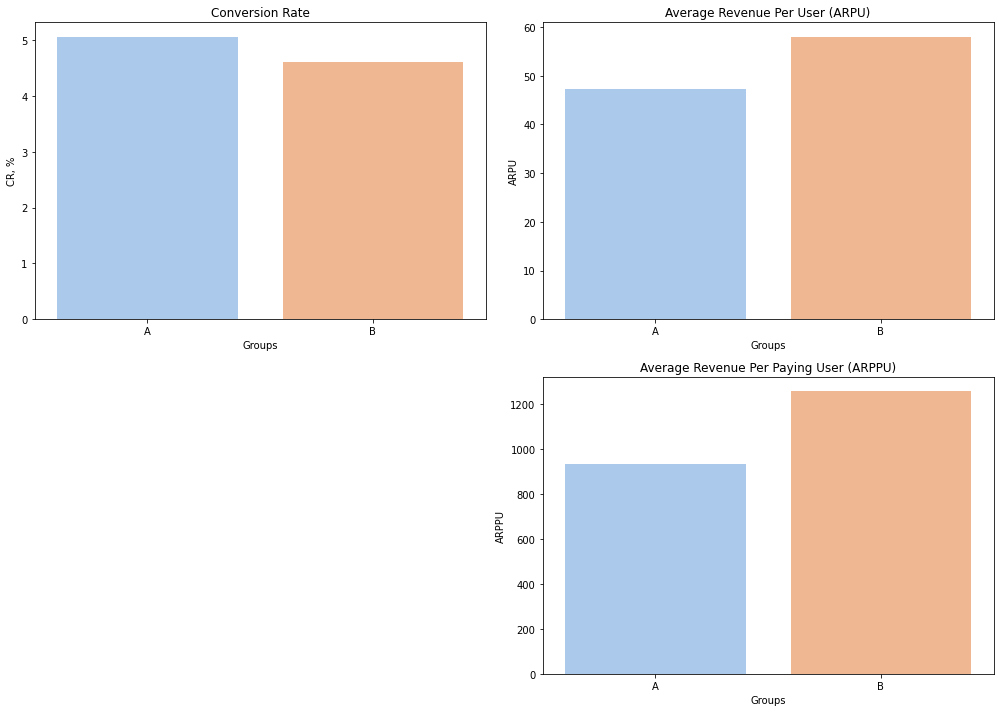

In [60]:
graphics(new_metric)